In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import abc
from abc import ABC, abstractmethod

from utils import eq_covariance,                 \
                  sample_datasets_from_gps,      \
                  gp_post_pred,                  \
                  np_plot_sample_and_predictions

# Sample and plot a few datapoints

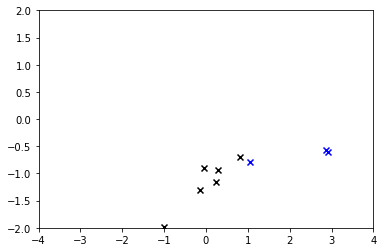

In [2]:
num_batches = 1
num_train = 8
num_test = 3
lengthscale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = False

train_data, test_data = sample_datasets_from_gps(num_batches,
                                                 num_train,
                                                 num_test,
                                                 lengthscale,
                                                 cov_coeff,
                                                 noise_coeff,
                                                 as_tensor)

plt.scatter(train_data[0][0], train_data[1][0], marker='x', color='black')
plt.scatter(test_data[0][0], test_data[1][0], marker='x', color='blue')

plt.xlim([-4, 4])
plt.ylim([-2, 2])
plt.show()

# NP definition

In [3]:
# class NeuralProcess(nn.Module):
    
#     def __init__(self,
#                  cond_lik,
#                  encoder,
#                  prior):
        
#         super().__init__()
        
#         self.cond_lik = cond_lik
#         self.encoder = encoder
#         self.prior = prior
        
#         self.normal = torch.distributions.Normal
        
        
#     def forward(self,
#                 context_inputs,
#                 context_outputs,
#                 target_inputs):
        
#         context_inputs = context_inputs.unsqueeze(dim=-1)
#         context_outputs = context_outputs.unsqueeze(dim=-1)
#         target_inputs = target_inputs.unsqueeze(dim=-1)
        
#         context = torch.cat([context_inputs, context_outputs], dim=-1)
        
#         theta_post_params = self.encoder(context)
#         theta_post_params = torch.mean(theta_post_params, dim=1)[:, None, :]
#         theta_post_params = torch.reshape(theta_post_params,
#                                           theta_post_params.shape[:-1] + (-1, 2))
        
#         theta_mean = theta_post_params[:, :, :, 0]
#         theta_stdev = torch.exp(theta_post_params[:, :, :, 1])
        
#         theta_post = torch.distributions.Normal(theta_mean, theta_stdev)
        
#         theta_sample = theta_post.rsample()
        
#         kl_divergence = torch.distributions.kl_divergence(theta_post, prior)
        
#         theta_sample = theta_sample.repeat(1, target_inputs.shape[1], 1)
#         tensor = torch.cat([target_inputs, theta_sample], dim=-1)
        
#         tensor = self.cond_lik(tensor)
#         tensor = torch.reshape(tensor, tensor.shape[:2] + (-1, 2))
        
#         mean, log_stdev = tensor[:, :, :, 0], tensor[:, :, :, 1]
        
#         return mean, log_stdev, kl_divergence, theta_sample
    
    
#     def _loss(self,
#               context_inputs,
#               context_outputs,
#               target_inputs,
#               target_outputs):
        
#         target_outputs = target_outputs.unsqueeze(dim=-1)
        
#         mean, log_stdev, kl_divergence, _ = self.forward(context_inputs,
#                                                          context_outputs,
#                                                          target_inputs)
        
#         stdev = torch.exp(log_stdev)
        
#         cond_dist = self.normal(loc=mean, scale=stdev)
        
#         log_prob = cond_dist.log_prob(target_outputs)
        
#         log_prob = torch.mean(log_prob, dim=0)
#         log_prob = torch.sum(log_prob)
        
#         kl_divergence = torch.sum(kl_divergence, dim=[1, 2])
#         kl_divergence = torch.mean(kl_divergence)
        
#         elbo = log_prob - 1e-1 * kl_divergence
        
#         return - elbo
    
    
#     def loss(self,
#              inputs,
#              outputs,
#              num_samples):
        
#         loss = 0
        
#         for i in range(num_samples):
            
#             N = np.random.choice(np.arange(1, inputs.shape[1]))
            
#             context_inputs = inputs[:, :N]
#             context_outputs = outputs[:, :N]
#             target_inputs = inputs[:, N:]
#             target_outputs = outputs[:, N:]
            
#             loss = loss + self._loss(context_inputs,
#                                      context_outputs,
#                                      target_inputs,
#                                      target_outputs)
        
#         loss = loss / num_samples
        
#         return loss

In [4]:
class FeedforwardNetwork(nn.Module):
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 nums_hidden,
                 nonlinearity):
        
        super().__init__()
        
        # Set sizes for linear layers
        sizes = [input_dim] + nums_hidden + [output_dim]
        sizes = [(s1, s2) for s1, s2 in zip(sizes[:-1], sizes[1:])]
        
        # Create linear layers
        self.linear = [nn.Linear(s1, s2, bias=True) for s1, s2 in sizes]
        self.linear = nn.ModuleList(self.linear)
        
        # Nonlinearity to use after each linear layer except the last
        self.nonlinearity = getattr(nn, nonlinearity)()
        
    
    def forward(self, tensor):
        
        # Apply each linear layer (except last) and nonlinearity
        for linear in self.linear[:-1]:
            
            tensor = linear(tensor)
            tensor = self.nonlinearity(tensor)
            
        # Apply last linear layer
        tensor = self.linear[-1](tensor)
        
        return tensor

In [5]:
class ConcatenationEncoder(nn.Module):
    
    def __init__(self,
                 transformation,
                 stochastic_layer):
        
        super().__init__()
        
        self.transformation = transformation
        self.stochastic_layer = stochastic_layer
    
    def forward(self,
                context_inputs,
                context_outputs):
        
        # Concatenate context inputs and outputs
        tensor = torch.cat([context_inputs, context_outputs], dim=-1)
        
        # Pass context tensor through transformation
        tensor = self.transformation(tensor)
        
        # Get approximate posterior parameters and distribution
        approx_post_params = torch.mean(tensor, dim=1)[:, None, :]
        approx_post = self.stochastic_layer(approx_post_params)
        
        return approx_post
        
    
class RepeatDecoder(nn.Module, ABC):
    
    def __init__(self,
                 transformation,
                 stochastic_layer):
        
        super().__init__()
        
        self.transformation = transformation
        self.stochastic_layer = stochastic_layer
    
    def forward(self,
                context,
                target_inputs):
        
        # Repeat context tensor for each datapoint
        context = context[:, None, :]
        context = context.repeat(1, target_inputs.shape[1], 1)
        
        # Concatenate inputs and context
        tensor = torch.cat([target_inputs, context], dim=-1)
        
        # Pass context tensor through transformation
        tensor = self.transformation(tensor)
        
        # Get approximate posterior parameters and distribution
        cond_lik = self.stochastic_layer(tensor)
        
        return cond_lik

In [6]:
class StochasticLayer(ABC):
    
    def __init__(self, distribution):
        
        # Set the distribution to use
        self.distribution_type = getattr(torch.distributions,
                                         distribution)
        
    @abstractmethod
    def reparametrise(self, tensor):
        pass
    
    def __call__(self, tensor):
        
        # Reparametrise raw tensor to get distribution parameters
        distribution_params = self.reparametrise(tensor)
        
        # Instantiate distribution using parameters
        distribution = self.distribution_type(**distribution_params)
        
        return distribution
    
    
class NormalStochasticLayer(StochasticLayer):
    
    def __init__(self):
        
        super().__init__(distribution='Normal')
        
        
    def reparametrise(self, tensor):
        
        tensor = torch.reshape(tensor, tensor.shape[:-2] + (-1, 2))
        
        param_dict = {'loc'   : tensor[..., 0],
                      'scale' : torch.exp(tensor[..., 1])}
        
        return param_dict

In [7]:
class NeuralProcess(nn.Module):
    
    def __init__(self,
                 encoder,
                 decoder,
                 prior):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.prior = prior
    
    
    def forward(self,
                context_inputs,
                context_outputs,
                target_inputs,
                sample=False):
        
        # Approximate posterior of (sub-sampled) context points
        context_approx_post = self.encoder(context_inputs,
                                           context_outputs)
            
        # Sample context from approximate posterior
        context_sample = context_approx_post.sample()
            
        # Pass target inputs and context sample through decoder
        cond_lik_dist = self.decoder(context_sample,
                                     target_inputs)
        
        # Sample output from conditional likelihood distribution
        if sample:
            return cond_lik_dist.sample()
        
        else:
            return cond_lik_dist.mean, cond_lik_dist.stddev
    
    
    def loss(self,
             inputs,
             outputs,
             num_mc_samples,
             num_subsamples):
        
        loss = 0.
        
        # Approximate posterior of all observed datapoints
        full_approx_post = self.encoder(inputs, outputs)
        
        for i in range(num_subsamples):
            
            # Number of context points
            N = np.random.choice(np.arange(1, outputs.shape[1] - 1))
            
            # Split context and target inputs/outputs
            context_inputs = inputs[:, :N]
            context_outputs = outputs[:, :N]
            target_inputs = inputs[:, N:]
            target_outputs = outputs[:, N:]
            
            # Approximate posterior of (sub-sampled) context points
            context_approx_post = self.encoder(context_inputs,
                                               context_outputs)

            # KL of full approx. posterior to context approx. posterior
            kl_divergence = torch.distributions.kl_divergence(full_approx_post,
                                                              context_approx_post)
            kl_divergence = torch.sum(kl_divergence, dim=-1)
            
            # Sample context from approximate posterior
            context_sample = context_approx_post.sample()
            
            # Pass target inputs and context sample through decoder
            cond_lik_dist = self.decoder(context_sample,
                                         target_inputs)
            
            # Compute log likeelihood of target outputs
            log_lik = cond_lik_dist.log_prob(target_outputs[..., 0])
            log_lik = torch.sum(log_lik, dim=-1)
            
            # Compute ELBO for current nuumber of subsamples
            elbo = log_lik - kl_divergence
            elbo = torch.mean(elbo)
            
            # Add negative elbo to overall loss
            loss = loss - elbo
            
        loss = loss / num_subsamples
        
        return loss

In [8]:
# Encoder modules
transformation = FeedforwardNetwork(input_dim=2,
                                    output_dim=256,
                                    nums_hidden=[128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer()

encoder = ConcatenationEncoder(transformation,
                               stochastic_layer)

# Decoder modules
transformation = FeedforwardNetwork(input_dim=129,
                                    output_dim=2,
                                    nums_hidden=[128, 128, 128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer()

decoder = RepeatDecoder(transformation,
                        stochastic_layer)


# Neural Process
prior = torch.distributions.Normal

neural_process = NeuralProcess(encoder,
                               decoder,
                               prior)

In [9]:
batch_size = 20
num_train = 40
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
plot_input_range = (-6., 6.)

train_data, test_data = sample_datasets_from_gps(batch_size,
                                                 num_train,
                                                 num_test,
                                                 scale,
                                                 cov_coeff,
                                                 noise_coeff,
                                                 as_tensor)

context_post = encoder.forward(train_data[0],
                               train_data[1])

context_sample = context_post.sample()

out_post = decoder.forward(context_sample,
                           test_data[0])

output = neural_process(train_data[0],
                        train_data[1],
                        test_data[1])

output = neural_process.loss(inputs=train_data[0],
                             outputs=train_data[1],
                             num_mc_samples=1,
                             num_subsamples=100)

# Training

torch.Size([1, 11, 1]) torch.Size([1, 11, 1]) torch.Size([1, 100, 1])


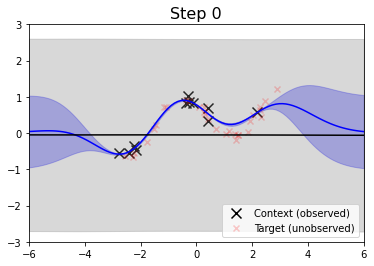

torch.Size([1, 6, 1]) torch.Size([1, 6, 1]) torch.Size([1, 100, 1])


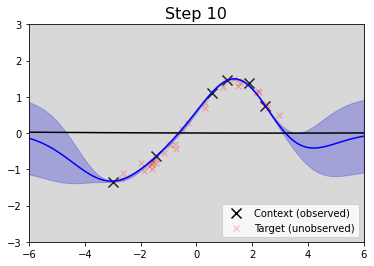

torch.Size([1, 21, 1]) torch.Size([1, 21, 1]) torch.Size([1, 100, 1])


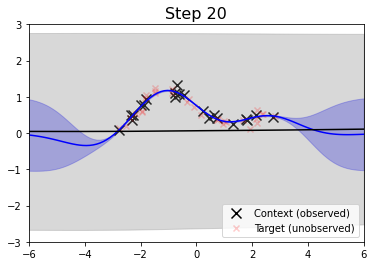

torch.Size([1, 10, 1]) torch.Size([1, 10, 1]) torch.Size([1, 100, 1])


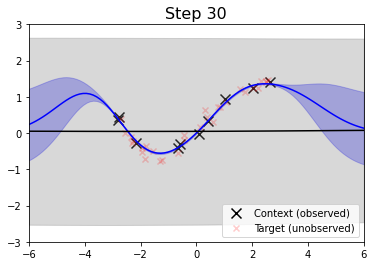

torch.Size([1, 38, 1]) torch.Size([1, 38, 1]) torch.Size([1, 100, 1])


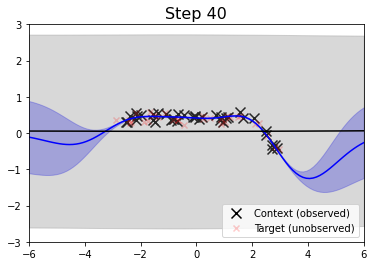

torch.Size([1, 1, 1]) torch.Size([1, 1, 1]) torch.Size([1, 100, 1])


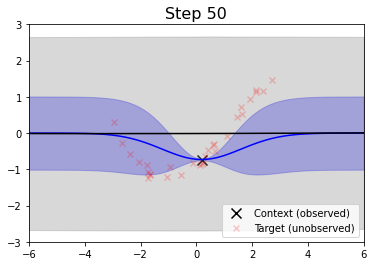

torch.Size([1, 14, 1]) torch.Size([1, 14, 1]) torch.Size([1, 100, 1])


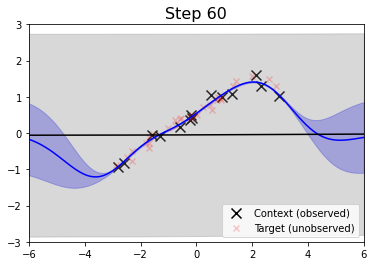

torch.Size([1, 13, 1]) torch.Size([1, 13, 1]) torch.Size([1, 100, 1])


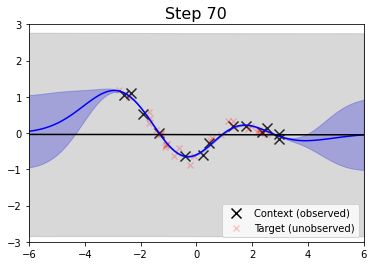

torch.Size([1, 35, 1]) torch.Size([1, 35, 1]) torch.Size([1, 100, 1])


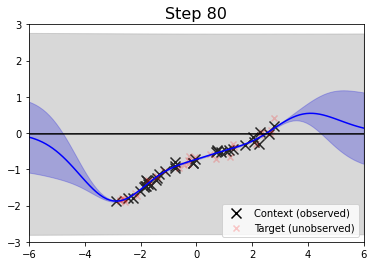

torch.Size([1, 17, 1]) torch.Size([1, 17, 1]) torch.Size([1, 100, 1])


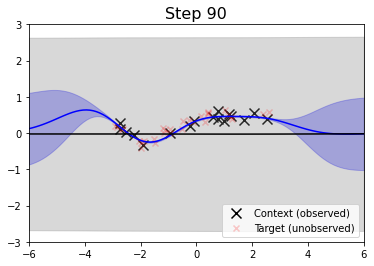

torch.Size([1, 33, 1]) torch.Size([1, 33, 1]) torch.Size([1, 100, 1])


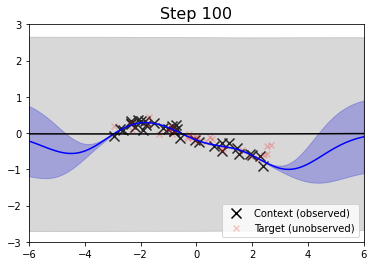

torch.Size([1, 6, 1]) torch.Size([1, 6, 1]) torch.Size([1, 100, 1])


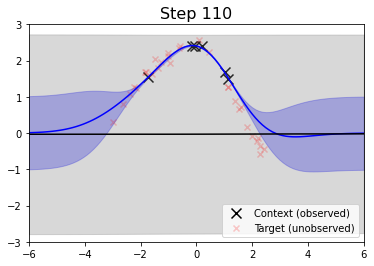

torch.Size([1, 11, 1]) torch.Size([1, 11, 1]) torch.Size([1, 100, 1])


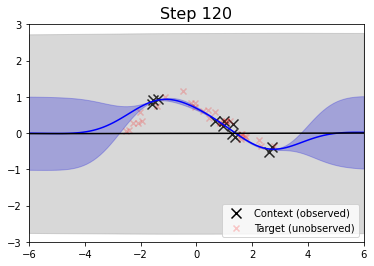

torch.Size([1, 31, 1]) torch.Size([1, 31, 1]) torch.Size([1, 100, 1])


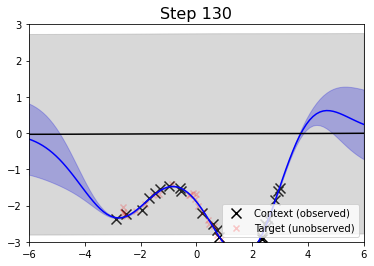

torch.Size([1, 37, 1]) torch.Size([1, 37, 1]) torch.Size([1, 100, 1])


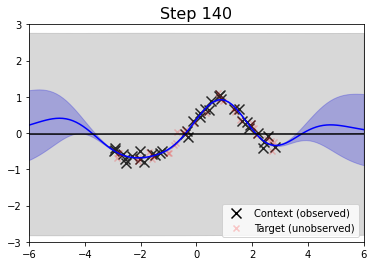

torch.Size([1, 24, 1]) torch.Size([1, 24, 1]) torch.Size([1, 100, 1])


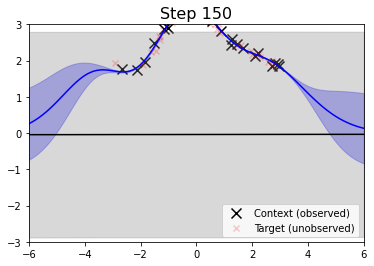

torch.Size([1, 33, 1]) torch.Size([1, 33, 1]) torch.Size([1, 100, 1])


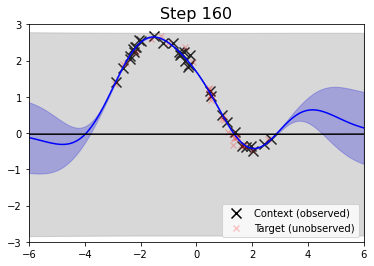

torch.Size([1, 11, 1]) torch.Size([1, 11, 1]) torch.Size([1, 100, 1])


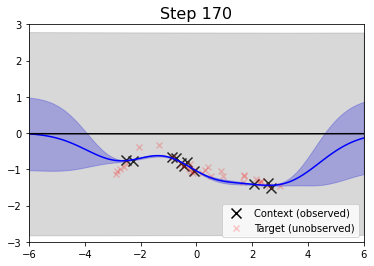

torch.Size([1, 23, 1]) torch.Size([1, 23, 1]) torch.Size([1, 100, 1])


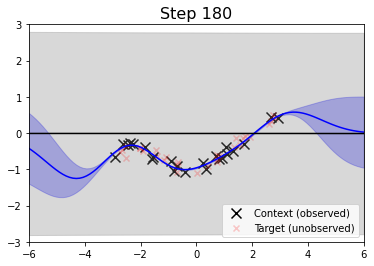

torch.Size([1, 39, 1]) torch.Size([1, 39, 1]) torch.Size([1, 100, 1])


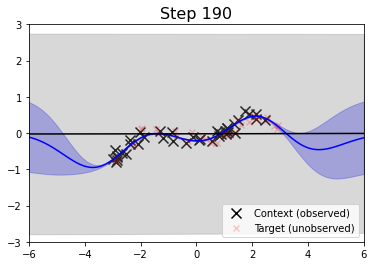

torch.Size([1, 3, 1]) torch.Size([1, 3, 1]) torch.Size([1, 100, 1])


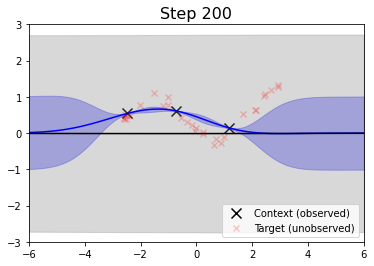

torch.Size([1, 29, 1]) torch.Size([1, 29, 1]) torch.Size([1, 100, 1])


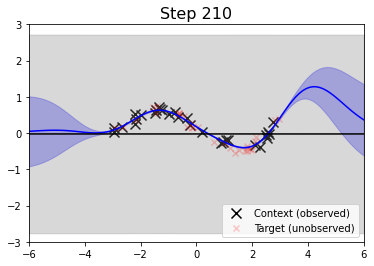

torch.Size([1, 20, 1]) torch.Size([1, 20, 1]) torch.Size([1, 100, 1])


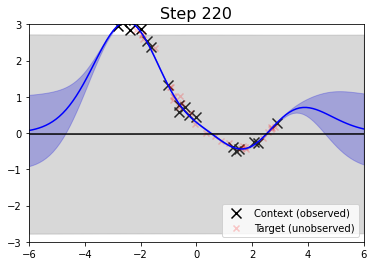

torch.Size([1, 17, 1]) torch.Size([1, 17, 1]) torch.Size([1, 100, 1])


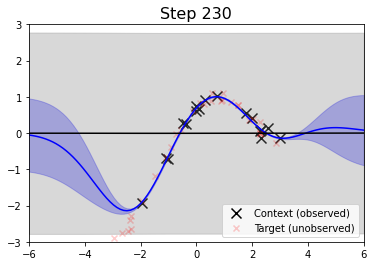

torch.Size([1, 6, 1]) torch.Size([1, 6, 1]) torch.Size([1, 100, 1])


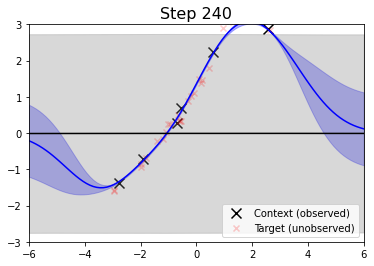

torch.Size([1, 2, 1]) torch.Size([1, 2, 1]) torch.Size([1, 100, 1])


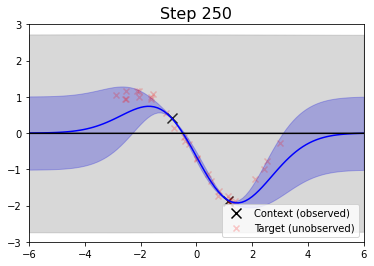

torch.Size([1, 23, 1]) torch.Size([1, 23, 1]) torch.Size([1, 100, 1])


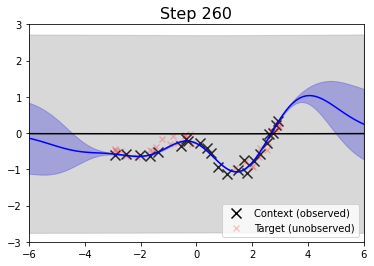

torch.Size([1, 6, 1]) torch.Size([1, 6, 1]) torch.Size([1, 100, 1])


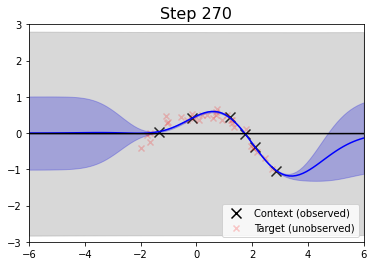

torch.Size([1, 7, 1]) torch.Size([1, 7, 1]) torch.Size([1, 100, 1])


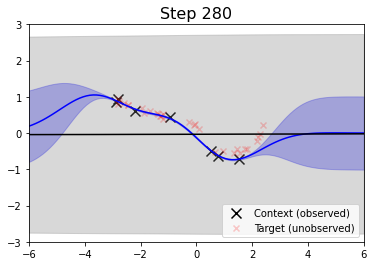

torch.Size([1, 36, 1]) torch.Size([1, 36, 1]) torch.Size([1, 100, 1])


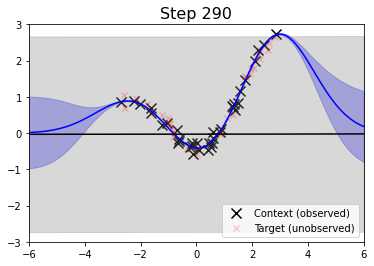

torch.Size([1, 20, 1]) torch.Size([1, 20, 1]) torch.Size([1, 100, 1])


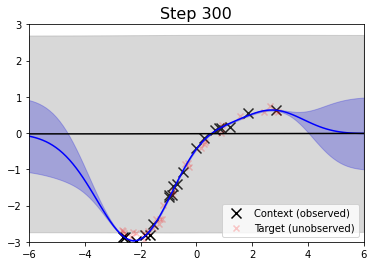

torch.Size([1, 27, 1]) torch.Size([1, 27, 1]) torch.Size([1, 100, 1])


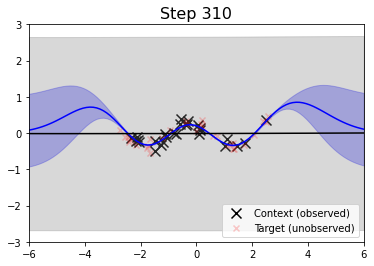

torch.Size([1, 10, 1]) torch.Size([1, 10, 1]) torch.Size([1, 100, 1])


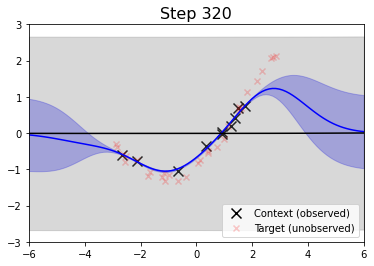

In [ ]:
# Dataset parameters
batch_size = 20
num_train = 40
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
plot_input_range = (-6., 6.)

# Training parameters and optimizer
num_train_steps = int(1e5)
lr = 1e-3

# Encoder modules
transformation = FeedforwardNetwork(input_dim=2,
                                    output_dim=256,
                                    nums_hidden=[128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer()

encoder = ConcatenationEncoder(transformation,
                               stochastic_layer)

# Decoder modules
transformation = FeedforwardNetwork(input_dim=129,
                                    output_dim=2,
                                    nums_hidden=[128, 128, 128, 128],
                                    nonlinearity='ReLU')

stochastic_layer = NormalStochasticLayer()

decoder = RepeatDecoder(transformation,
                        stochastic_layer)


# Neural Process
prior = torch.distributions.Normal

neural_process = NeuralProcess(encoder,
                               decoder,
                               prior)

# Optimizer
optimizer = torch.optim.Adam(neural_process.parameters(), lr=lr)

losses = []

for i in range(num_train_steps):
    
    train_data, test_data = sample_datasets_from_gps(batch_size,
                                                     num_train,
                                                     num_test,
                                                     scale,
                                                     cov_coeff,
                                                     noise_coeff,
                                                     as_tensor)
    
    inputs, outputs = train_data
    
    loss = neural_process.loss(inputs=train_data[0],
                               outputs=train_data[1],
                               num_mc_samples=1,
                               num_subsamples=2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 1e1 == 0:
        
        num_train_plot = np.random.choice(np.arange(1, num_train))
        
        np_plot_sample_and_predictions(neural_process,
                                       input_range=plot_input_range,
                                       num_train=num_train_plot,
                                       num_test=30,
                                       scale=scale,
                                       cov_coeff=cov_coeff,
                                       noise_coeff=noise_coeff,
                                       step=i,
                                       plot_test_data=True)

In [ ]:
# Dataset parameters
num_train = 2
num_test = 5
scale = 1.
cov_coeff = 1e0
noise_coeff = 1e-1
as_tensor = True
input_range = (-6., 6.)


train_data, test_data = sample_datasets_from_gps(batch_size=1,
                                                 num_train=num_train,
                                                 num_test=num_test,
                                                 scale=scale,
                                                 cov_coeff=cov_coeff,
                                                 noise_coeff=noise_coeff,
                                                 as_tensor=True)

context_inputs, context_outputs = train_data
target_inputs = torch.linspace(input_range[0],
                               input_range[1],
                               100)[None, :]

for i in range(10):
    
    pred_mean, _, _, _ = neural_process.forward(context_inputs,
                                                context_outputs,
                                                target_inputs)
    
    pred_mean = pred_mean[0, :, 0].detach().numpy()
    
    plt.plot(target_inputs[0], pred_mean, color='black', zorder=1)
    plt.scatter(train_data[0], train_data[1], color='red', s=100, zorder=2)
    
plt.xlim([-6., 6.])
plt.ylim([-2., 2.])